<a href="https://colab.research.google.com/github/sayakpaul/Emotion-Detection-using-Deep-Learning/blob/master/v2_Emotion_Detection_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Select TensorFlow 2.0 environment
%tensorflow_version 2.x

TensorFlow 2.x selected.


You need to get your API key from your Kaggle account to be able to proceed with the following. 

In [0]:
# Google Colab imports for setting up Kaggle
from google.colab import files
files.upload()

In [0]:
# Set up Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Download the data
# https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [0]:
# Unzip dataset
!unzip -qq icml_face_data.csv.zip
!unzip -qq test.csv.zip
!unzip -qq train.csv.zip

In [0]:
# General imports
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [8]:
# Load up the training dataset
train = pd.read_csv("train.csv")
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [9]:
# Class distribution
train["emotion"].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

Class imbalance noticed.

In [10]:
# Load test dataset
test = pd.read_csv("test.csv")
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


Note on the label mapping:

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [0]:
# Function to clean the dataset
# Taken from http://bit.ly/37AUk7f
def clean_data(dataframe):
    image_pixels = np.zeros(shape=(len(dataframe), 48, 48))
    labels = np.zeros(shape=(len(dataframe), ))
    for (i, row) in tqdm(dataframe.iterrows()):
        image = np.fromstring(row["pixels"], dtype=int, sep=' ')
        image = image.reshape(48, 48)
        image = image.astype("float")/255
        
        image_pixels[i] = image
        labels[i] = row["emotion"]
    
    return (image_pixels, labels)

In [12]:
# Clean the training dataset and verify the shapes
(train_pixels, train_labels) = clean_data(train)
train_pixels.shape, train_labels.shape

28709it [00:05, 5618.68it/s]


((28709, 48, 48), (28709,))

In [0]:
# sklearn and other utility imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [0]:
# One-hot encode the labels
le = LabelEncoder().fit(train_labels)
train_labels = to_categorical(le.transform(train_labels), 7)

In [15]:
train_labels.shape

(28709, 7)

In [16]:
# Split the training data into further partial training and validation data
(trainX, valX, trainY, valY) = train_test_split(train_pixels,
    train_labels, test_size=0.15, stratify=train_labels, random_state=42)
trainX.shape, trainY.shape, valX.shape, valY.shape

((24402, 48, 48), (24402, 7), (4307, 48, 48), (4307, 7))

In [0]:
# Account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [0]:
# Define the label mapping
LABELS = {
    0: "Angry", 
    1: "Disgust", 
    2: "Fear",
    3: "Happy", 
    4: "Sad", 
    5: "Surprise", 
    6: "Neutral"
}

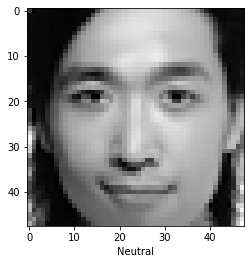

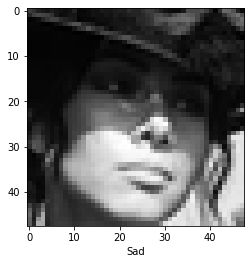

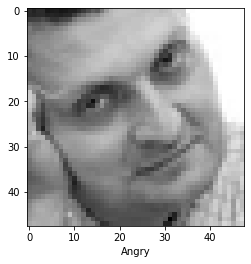

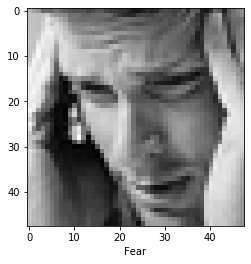

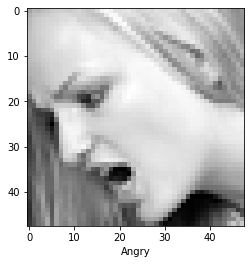

In [19]:
# Spot check the dataset
train_idx = np.random.choice(len(trainX), 5)
for id in train_idx:
    plt.imshow(trainX[id].reshape(48, 48), cmap="gray")
    plt.xlabel(LABELS[np.argmax(trainY[id])])
    plt.show()

In [0]:
# Convnets would require a channel dimension
trainX = trainX.reshape(-1, 48, 48, 1)
valX = valX.reshape(-1, 48, 48, 1)

In [0]:
# Set up wandb
!pip install wandb
!wandb login

In [0]:
# Import wandb
import wandb
from wandb.keras import WandbCallback

In [0]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
import math

Let's try Layer-Wise Sequential Unit Variance (LSUV) to initialize our network. LSUV was introduced in a paper called [All you need is a good init](https://arxiv.org/pdf/1511.06422.pdf) by Mishkin et. al. I have referred the Keras implementation from here: https://github.com/suvojit-0x55aa/LSUV-Keras. 

In [0]:
def seq_mini_vgg(channels=1, classes=7):

    mini_vgg_seq = Sequential()
    
    mini_vgg_seq.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu", 
        input_shape=(48, 48, channels)))
    mini_vgg_seq.add(BatchNormalization(axis=-1))
    mini_vgg_seq.add(Conv2D(32, (3, 3), strides=2, padding="same", activation="relu"))
    mini_vgg_seq.add(BatchNormalization(axis=-1))
    mini_vgg_seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    mini_vgg_seq.add(Conv2D(32, (3, 3), strides=2, padding="same", activation="relu"))
    mini_vgg_seq.add(BatchNormalization(axis=-1))
    mini_vgg_seq.add(Conv2D(32, (3, 3), strides=2, padding="same", activation="relu"))
    mini_vgg_seq.add(BatchNormalization(axis=-1))
    mini_vgg_seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    mini_vgg_seq.add(GlobalAveragePooling2D())
    mini_vgg_seq.add(Dense(512, activation="relu"))
    mini_vgg_seq.add(BatchNormalization())
    mini_vgg_seq.add(Dropout(0.5))
    mini_vgg_seq.add(Dense(classes, activation="softmax"))
    
    return mini_vgg_seq

In [25]:
!wget https://raw.githubusercontent.com/suvojit-0x55aa/LSUV-Keras/master/lib/lsuv.py

--2020-02-01 08:52:04--  https://raw.githubusercontent.com/suvojit-0x55aa/LSUV-Keras/master/lib/lsuv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598 (2.5K) [text/plain]
Saving to: ‘lsuv.py’

lsuv.py             100%[===================>]   2.54K  --.-KB/s    in 0s      

2020-02-01 08:52:05 (45.2 MB/s) - ‘lsuv.py’ saved [2598/2598]



In [0]:
from lsuv import LSUVinitialize

In [27]:
mini_vgg_v2 = seq_mini_vgg(classes=len(LABELS))
mini_vgg_v2.compile(loss="categorical_crossentropy", optimizer="sgd",
	metrics=["accuracy"])
mini_vgg_v2 = LSUVinitialize(mini_vgg_v2, trainX[:64,:,:,:])

Init Layer conv2d
0.13916174
Init Layer conv2d_1
0.25711745
Init Layer conv2d_2
0.27090916
Init Layer conv2d_3
0.15892583
Init Layer dense
0.2414849
dense_1 too small
LSUV: total layers initialized 5


In [28]:
wandb.init(project="emotion-detection", entity="sayakpaul", id="mini-vgg-wo-data-aug-sgd-lsuv")
mini_vgg_v2.fit(trainX, trainY, 
    batch_size=64,
    validation_data=(valX, valY),
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24402/24402 [==============================] - 5s 205us/sample - loss: 2.3542 - accuracy: 0.2114 - val_loss: 1.8102 - val_accuracy: 0.2877
Epoch 2/50
24402/24402 [==============================] - 4s 152us/sample - loss: 1.8532 - accuracy: 0.3076 - val_loss: 1.6654 - val_accuracy: 0.3497
Epoch 3/50
24402/24402 [==============================] - 4s 151us/sample - loss: 1.6838 - accuracy: 0.3499 - val_loss: 1.6491 - val_accuracy: 0.3620
Epoch 4/50
24402/24402 [==============================] - 4s 155us/sample - loss: 1.6084 - accuracy: 0.3745 - val_loss: 1.5730 - val_accuracy: 0.3947
Epoch 5/50
24402/24402 [==============================] - 4s 149us/sample - loss: 1.5566 - accuracy: 0.3976 - val_loss: 1.5542 - val_accuracy: 0.4014
Epoch 6/50
24402/24402 [==============================] - 4s 149us/sample - loss: 1.5265 - accuracy: 0.4041 - val_loss: 1.5282 - val_accuracy: 0.4186
Epoch 7/50
24402/24402 [===========================